# Manage optogenetics experiments with DataJoint Elements

In this tutorial, we will walk through storing optogenetic stimulus data with the DataJoint Workflow for Optogenetics.

We will explain the following concepts as they relate to this workflow:
- What is an Element versus a Workflow?
- Plot the workflow with `dj.Diagram`
- Insert data into tables
- Query table contents
- Fetch table contents
- Run the workflow for your experiments

For detailed documentation and tutorials on general DataJoint principles that support collaboration, automation, reproducibility, and visualizations:

- [DataJoint Interactive Tutorials](https://github.com/datajoint/datajoint-tutorials) - Fundamentals including table tiers, query operations, fetch operations, automated computations with the `make` function, etc.

- [DataJoint Core - Documentation](https://datajoint.com/docs/core/) - Relational data model principles

- [DataJoint API for Python - Documentation](https://datajoint.com/docs/core/datajoint-python/)

- [DataJoint Element for Optogenetics - Documentation](https://datajoint.com/docs/elements/element-optogenetics/)

Let's start by importing the packages necessary to run this workflow. 

In [1]:
import datajoint as dj

## The DataJoint Workflow for Optogenetics is assembled from 4 DataJoint Elements

| Element | Source Code | Documentation | Description |
| -- | -- | -- | -- |
| Element Lab | [Link](https://github.com/datajoint/element-lab) | [Link](https://datajoint.com/docs/elements/element-lab) | Lab management related information, such as Lab, User, Project, Protocol, Source. |
| Element Animal | [Link](https://github.com/datajoint/element-animal) | [Link](https://datajoint.com/docs/elements/element-animal) | General animal metadata and surgery information. |
| Element Session | [Link](https://github.com/datajoint/element-session) | [Link](https://datajoint.com/docs/elements/element-session) | General information of experimental sessions. |
| Element Optogenetics | [Link](https://github.com/datajoint/element-optogenetics) | [Link](https://datajoint.com/docs/elements/element-optogenetics) |  Optogenetics stimulus and timing data. |

Each workflow is composed of multiple Elements. Each Element contains 1 or more modules, and each module declares its own schema in the database.

The Elements are imported within the `workflow_optogenetics.pipeline` script.

By importing the modules for the first time, the schemas and tables will be created in the database.  Once created, importing modules will not create schemas and tables again, but the existing schemas/tables can be accessed.

The schema diagram (shown below) is a good reference for understanding the order of the tables within the workflow.

Let's activate the Elements.

In [2]:
from workflow_optogenetics.pipeline import lab, subject, surgery, session, optogenetics, Device

[2023-04-17 02:17:46,707][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-04-17 02:17:46,711][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-04-17 02:17:46,727][INFO]: Connected root@fakeservices.datajoint.io:3306


## Diagram

We can plot the diagram of tables within multiple schemas and their dependencies using `dj.Diagram()`.  For details, see the [documentation](https://datajoint.com/docs/core/concepts/getting-started/diagrams/).

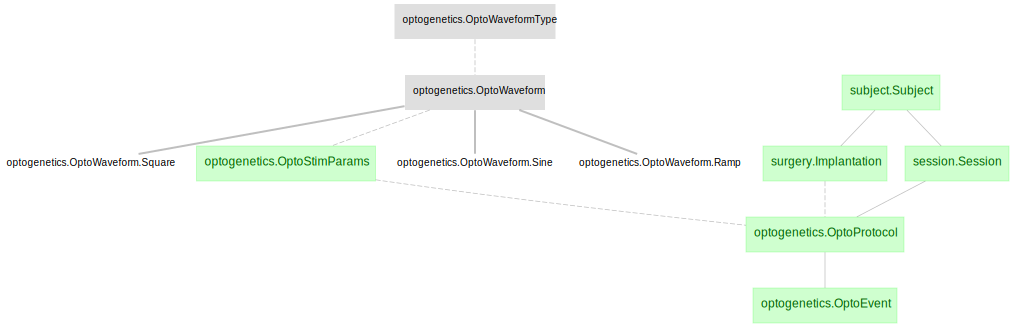

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(surgery.Implantation)
    + dj.Diagram(session.Session)
    + dj.Diagram(Device)
    + dj.Diagram(optogenetics)
)

While the diagram above seems complex at first, it becomes more clear when it's approached as a hierarchy of tables that define the order in which the workflow expects to receive data in each of its tables.

The tables higher up in the diagram such as `subject.Subject()` should be the first to receive data.

Data is manually entered into the green, rectangular tables with the `insert1()` method.

Tables connected by a solid line depend on entries from the table above it.

There are 5 table tiers in DataJoint. Some of these tables appear in the diagram above.

| Table tier | Color and shape | Description |
| -- | -- | -- |
| Manual table | Green box | Data entered from outside the pipeline, either by hand or with external helper scripts. |
| Lookup table | Gray box | Small tables containing general facts and settings of the data pipeline; not specific to any experiment or dataset. |  
| Imported table | Blue oval | Data ingested automatically inside the pipeline but requiring access to data outside the pipeline. |
| Computed table | Red circle | Data computed automatically entirely inside the pipeline. |
| Part table | Plain text | Part tables share the same tier as their master table. |

## Insert entries into manual tables

In this section, we will insert metadata about an animal subject, experiment session, and optogenetic stimulation parameters.

Let's start with the first schema and table in the schema diagram (i.e. `subject.Subject` table).

Each module (e.g. `subject`) contains a schema object that enables interaction with the schema in the database.

In [ ]:
subject.schema

The table classes in the module corresponds to a table in the database.

In [ ]:
subject.Subject()

We can view the table dependencies and the attributes we need to insert by using the functions `.describe()` and `.heading`.  The `describe()` function displays the table definition with foreign key references and the `heading` function displays the attributes of the table definition.  These are particularly useful functions if you are new to DataJoint Elements and are unsure of the attributes required for each table.

In [ ]:
subject.Subject.describe()

In [ ]:
subject.Subject.heading

We will insert data into the `subject.Subject` table. 

In [ ]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="Optogenetic pilot subject",
    )
)
subject.Subject()

Let's continue inserting in the other manual tables.  The `Session` table is next.

In [ ]:
session.Session.describe()

In [ ]:
session.Session.heading

The cells above show the dependencies and attributes for the `session.Session` table.

Notice that `describe` shows the dependencies of the table on upstream tables (i.e. foreign key references). The `Session` table depends on the upstream `Subject` table. 

Whereas `heading` lists all the attributes of the `Session` table, regardless of
whether they are declared in an upstream table.

In [ ]:
session.Session.insert1(
    dict(
        subject="subject1", 
        session_id="1", 
        session_datetime="2022-04-04 12:22:15.032"
     )
)
session.Session()

The `OptoProtocol` table's attributes include the `Session` and `Device` tables.  Let's insert into the `Device` table.

In [ ]:
Device.insert1(
    dict(
        device="OPTG_8",
        modality="Optogenetics",
        description="8 channel pulse sequence device",
    )
)

The `surgery.Implantation` table's attribute includes the `User` table.  Let's insert into the `User` table. 

In [ ]:
lab.User.insert1(
    dict(user="User1")
)

The `Implantation` table's attributes includes the `CoordinateReference` and `Hemisphere` tables.  Let's view the contents of these lookup tables, which have default contents.

In [ ]:
surgery.CoordinateReference()

In [ ]:
surgery.Hemisphere()

Insert a new entry for the location of the optogenetics probe.

In [ ]:
surgery.BrainRegion.insert1(
    dict(
        region_acronym="dHP", 
        region_name="Dorsal Hippocampus")
)

surgery.Implantation.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implant_type="optogenetics",
        target_region="dHP",
        target_hemisphere="left",
        surgeon="User1",
    )
)

surgery.Implantation.Coordinate.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implant_type="optogenetics",
        target_region="dHP",
        target_hemisphere="left",
        ap="-7.9",      # [mm] anterior-posterior distance
        ap_ref="bregma",
        ml="-1.8",      # [mm] medial axis distance
        ml_ref="bregma",
        dv="5",         # [mm] dorso-ventral axis distance
        dv_ref="skull_surface",
        theta="11.5",   # [0, 180] degree rotation about ml-axis relative to z
        phi="0",        # [0, 360] degree rotation about dv-axis relative to x
        beta=None,      # [-180, 180] degree rotation about shank relative to anterior
    )
)

We'll add information to describe the stimulus, including waveform shape and and stimulation parameters.

In [ ]:
optogenetics.OptoWaveform.insert1(
    dict(
        waveform_name="square_10",
        waveform_type="square",
        waveform_description="Square waveform: 10%/90% on/off cycle",
    )
)

# Square is one part table of OptoWaveform.
# For sine and ramp waveforms, see the corresponding tables.
optogenetics.OptoWaveform.Square.insert1(
    dict(
        waveform_name="square_10", 
        on_proportion=0.10, 
        off_proportion=0.90)
)

In [ ]:
optogenetics.OptoStimParams.insert1(
    dict(
        opto_params_id=1,
        waveform_name="square_10",
        wavelength=470,
        light_intensity=10.2,
        frequency=1,
        duration=241,
    )
)

Next, we'll describe the session in which these parameters are used in `OptoProtocol`.

In [ ]:
optogenetics.OptoProtocol.insert1(
    dict(
        subject="subject1",
        session_id="1",
        protocol_id="1",
        opto_params_id="1",
        implant_date="2022-04-01 12:13:14",
        implant_type="optogenetics",
        target_region="dHP",
        target_hemisphere="left",
        device="OPTG_4",
    )
)

We can describe the timing of these stimulations in `OptoEvent`.

In [ ]:
optogenetics.OptoEvent.insert(
    dict(
        subject="subject1",
        session_id=1,
        protocol_id=1,
        stim_start_time=241,
        stim_end_time=482,
    )
)

We can insert a  second set of timing information for the stimulation.

In [ ]:
optogenetics.OptoEvent.insert(
    dict(
        subject="subject1",
        session_id=1,
        protocol_id=1,
        stim_start_time=543,
        stim_end_time=797,
    )
)

## Query

Queries allow you to view the contents of the database.  The simplest query is the instance of the table class.

In [ ]:
optogenetics.OptoEvent()

With the `&` operator, we will restrict the contents of the `OptoEvent` table to those entries with a `stim_start_time` of 543.

In [ ]:
optogenetics.OptoEvent & "stim_start_time=543"

DataJoint queries can be a highly flexible tool with several [operators](https://datajoint.com/docs/core/concepts/query-lang/operators/).  The next operator we will explore is `join` which combines matching information from tables.

In [ ]:
optogenetics.OptoProtocol * optogenetics.OptoStimParams

## Fetch

The `fetch` and `fetch1` methods download the data from the query object into the workspace.

Below we will run `fetch()` without any arguments to return a list of dictionaries containing all attributes of all entries in the table.

In [ ]:
optogenetics.OptoEvent.fetch()

Next, we will fetch the entry with a `stim_start_time` of 543 with the `fetch1` method, which returns a dictionary containing all attributes of one entry in the table.

In [ ]:
(optogenetics.OptoEvent & "stim_start_time=543").fetch1()

## Next steps

Follow the steps below to run this workflow for your experiments:

- Create a fork of this repository to your GitHub account.
- Clone the repository to your local machine and configure for use with the instructions in the [User Guide](https://datajoint.com/docs/elements/user-guide/).
- The DataJoint team offers free [Office Hours](https://datajoint.com/docs/community/support/) to help you setup this workflow.
- If you have any questions, please reach out at support@datajoint.com.